The HIPPO model defines a state space model, that features a parameter matrix A (the HIPPO matrix) that makes the model particularly good at remembering input. HIPPO plays a key role in the S4 model for the initialisation of its parameters (which are then further optimized given its training data). In this notebook, we have a closer look at the HIPPO matrix and try to assess the effects this matrix has on the autonomous dynamics of the model.

In [15]:
import pyolite
#pyolite.__version__
import numpy as np

The state space model (SSM) is defined as below, with $u(t)$ as the input time series, and $y(t)$ as the output time series, and $x(t)$ as the hidden state vector.

$$ \dot{x} = Ax + Bu \\ y = Cx + Du $$

The $A$ matrix in the ODE that defines the dynamics of $x$ is our key topic. The HIPPO paper derives one surprisingly simple closed form for it.

In [17]:
#copied from: https://srush.github.io/annotated-s4/
def make_HiPPO(N):
    def v(n, k):
        if n > k:
            return np.sqrt(2 * n + 1) * np.sqrt(2 * k + 1)
        elif n == k:
            return n + 1
        else:
            return 0

    # Do it slow so we don't mess it up :)
    mat = [[v(n, k) for k in range(1, N + 1)] for n in range(1, N + 1)]
    return np.array(mat)

In [18]:
hippo256 = make_HiPPO(256)

In [34]:
hippo256[250,250]

252.0

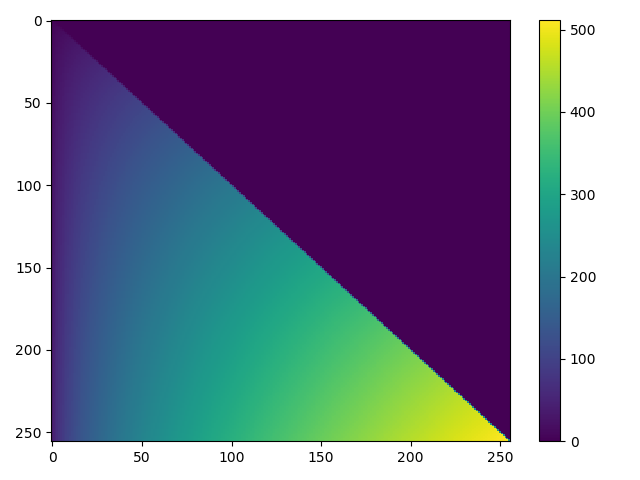

In [19]:
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
#import seaborn as sns #seaborn unavilable for jupyter lite
A = hippo256
im = plt.imshow(A, cmap='viridis', interpolation='none', aspect='auto')

ax = plt.gca()
cbar = ax.figure.colorbar(im, ax=ax)
#cbar.ax.set_ylabel("cmap", rotation=-90, va="bottom")

plt.tight_layout()
plt.show()

In [14]:
from numpy import linalg as LA

hippo8 = make_HiPPO(8)
w, v = LA.eig(hippo8)
print(w) # eigenvalues
print(v) # eigenvectors

[9. 8. 7. 6. 5. 4. 3. 2.]
[[ 0.          0.          0.          0.          0.          0.
   0.          0.00833333]
 [ 0.          0.          0.          0.          0.          0.
   0.0021645  -0.03227486]
 [ 0.          0.          0.          0.          0.          0.00126263
  -0.01280537  0.07637626]
 [ 0.          0.          0.          0.          0.0013986  -0.01002179
   0.04355977 -0.14433757]
 [ 0.          0.          0.          0.00274725 -0.01391591  0.044318
  -0.11236664  0.23935678]
 [ 0.          0.          0.00952381 -0.03285236  0.07564094 -0.14453624
   0.24431084 -0.36429155]
 [ 0.          0.0625     -0.13299276  0.2117346  -0.2979218   0.38814207
  -0.47237749  0.52174919]
 [ 1.         -0.99804496  0.99107125 -0.97677102  0.95148591 -0.90905934
   0.83814041 -0.71414284]]


The $B$ matrix is also given: $$B_n = (2n + 1)^{1/2}$$

 The paper discusses how to convert the continuous time SSM into a discrete time Recurrent Neural Network. The weights for the recurrent connections are in matrix $\bar{A}$, which is given by the following formula: 
 
 
 $$\bar{A} = (I − Δ/2 · A)^{−1}(I + Δ/2 · A)$$

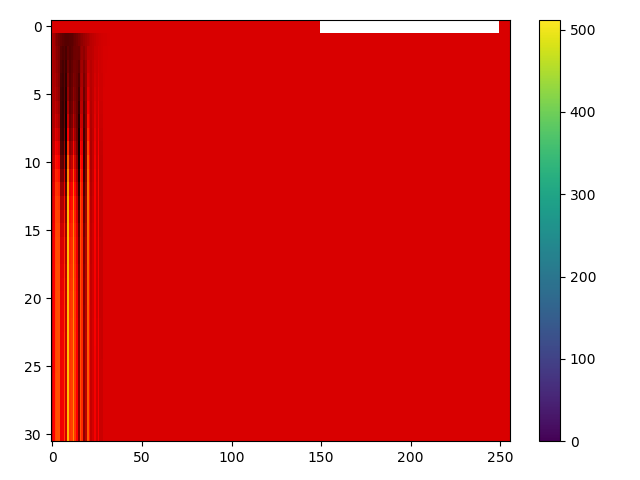

In [31]:
from numpy.linalg import inv

r = np.zeros(256)
#r[254]=1 
r[150:250] = 1.0 #r[20:30] = 1.0

lst = []
lst.append(r)

gamma = 0.005 # == Delta/2
A = hippo256;

Abar = np.multiply(inv(np.identity(256) - (gamma * A)),np.identity(256) + (gamma * A))

for i in range(30):
    r = np.matmul(r,Abar)
    lst.append(r/np.linalg.norm(r))

plt.imshow(lst, cmap='hot', interpolation='none',aspect='auto')

ax = plt.gca()
cbar = ax.figure.colorbar(im, ax=ax)

plt.show()

In [39]:
#copied from: https://srush.github.io/annotated-s4/

def example_legendre(N=16):
    # Random hidden state as coefficients
    import numpy as np
    import numpy.polynomial.legendre

    x = (np.random.rand(N) - 0.5) * 2
    t = np.linspace(-1, 1, 100)
    f = numpy.polynomial.legendre.Legendre(x)(t)
    
    # Plot
    import matplotlib.pyplot as plt
    #import seaborn

    #seaborn.set_context("talk")
    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection="3d")
    ax.plot(
        np.linspace(-25, (N - 1) * 100 + 25, 100),
        [0] * 100,
        zs=-1,
        zdir="x",
        color="black",
    )
    ax.plot(t, f, zs=N * 100, zdir="y", c="r")
    for i in range(N):
        coef = [0] * N
        coef[N - i - 1] = 1
        ax.set_zlim(-4, 4)
        ax.set_yticks([])
        ax.set_zticks([])
        # Plot basis function.
        f = numpy.polynomial.legendre.Legendre(coef)(t)
        ax.bar(
            [100 * i],
            [x[i]],
            zs=-1,
            zdir="x",
            label="x%d" % i,
            color="yellow",
            fill=False,
            width=50,
        )
        ax.plot(t, f, zs=100 * i, zdir="y", c="b", alpha=0.5)
    ax.view_init(elev=40.0, azim=-45)
    plt.show()
    #fig.savefig("images/leg.png")

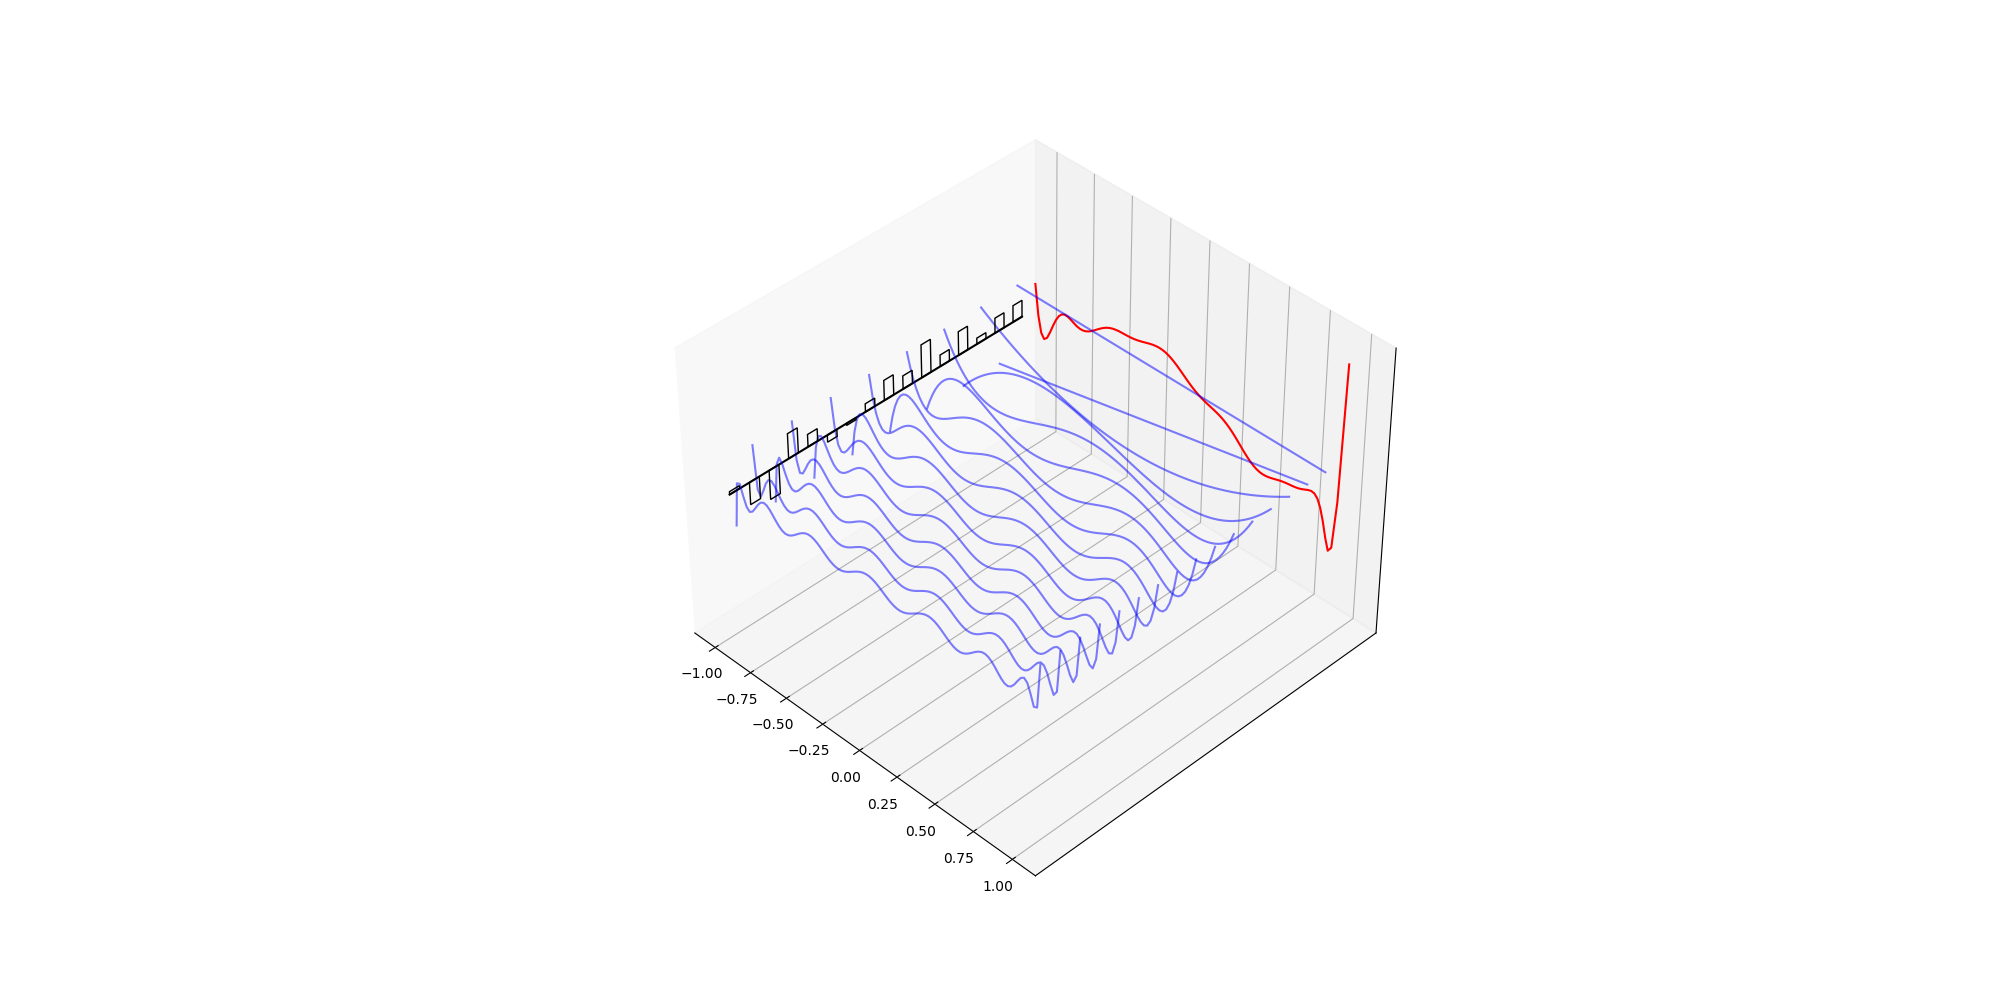

In [40]:
example_legendre()